# XGBoost

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.metrics import confusion_matrix

import pickle

## 1.BOW

In [4]:
# loading BOW vectors

X_train_bow = pickle.load(open('bow_vectors/X_train_bow','rb'))
X_test_bow = pickle.load(open('bow_vectors/X_test_bow','rb'))
bow_features = pickle.load(open('bow_vectors/bow_features','rb'))

y_train = np.load('split dataset/y_train.npy',allow_pickle = True)
y_test = np.load('split dataset/y_test.npy',allow_pickle = True)

In [9]:
xgbc = XGBClassifier(n_jobs = -1, class_weight = 'balanced')
num_estimator = [5,10,50,100,120]
maximum_depth = [1, 5, 7, 10, 15, 25, 30]
parameter = {
    'n_estimators': num_estimator,
    'max_depth': maximum_depth
}
grid = GridSearchCV(estimator = xgbc , param_grid = parameter , cv =5, n_jobs=-1, scoring= 'roc_auc', return_train_score = True )
grid.fit(X_train_bow,y_train)

print('Best Parameter:',grid.best_params_)

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:07:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:07:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:07:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:07:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:

Best Parameter: {'max_depth': 10, 'n_estimators': 120}


In [11]:
train_auc = grid.cv_results_['mean_train_score'].reshape(7,5)
test_auc = grid.cv_results_['mean_test_score'].reshape(7,5)

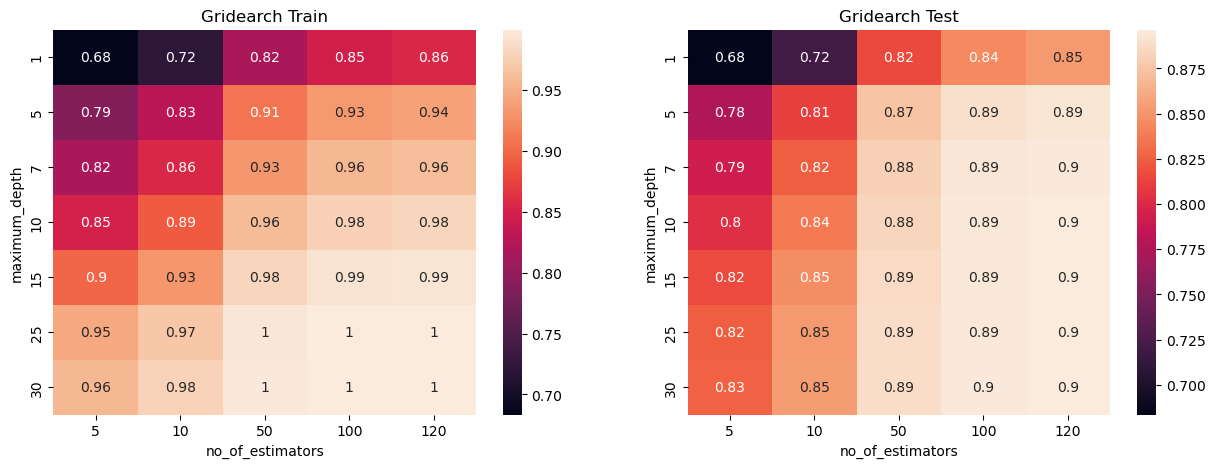

In [13]:
f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
    title = train_auc if i ==0 else test_auc
    sns.heatmap(title,xticklabels = num_estimator, yticklabels = maximum_depth, annot =True, ax = axes[i])
    axes[i].set_title(f"Gridearch {'Train' if i==0 else 'Test'}")
    axes[i].set_xlabel("no_of_estimators")
    axes[i].set_ylabel("maximum_depth") 

#### here we can see that at max_dept = 10 and number of estimator =120 model have good score

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


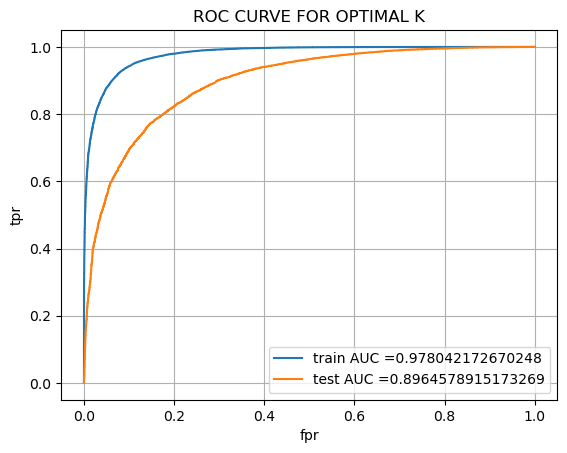

Area under train roc 0.978042172670248
Area under test roc 0.8964578915173269


In [24]:
xgbc_bp = XGBClassifier(**grid.best_params_,class_weight = 'balanced')
xgbc_bp = xgbc_bp.fit(X_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, xgbc_bp.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, xgbc_bp.predict_proba(X_test_bow)[:,1])
plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

In [26]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()


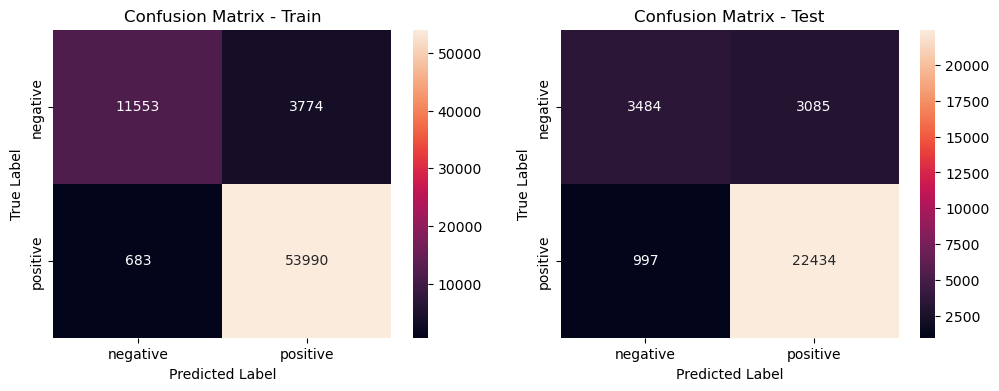

In [28]:
plot_confusion_matrixes(xgbc_bp,X_train_bow,y_train,X_test_bow,y_test)

Top 20 features are: 
                     coef
return          0.011402
perfect         0.009996
delicious       0.007763
excellent       0.007539
highly          0.007023
throw           0.006674
waste           0.006631
disappointed    0.006295
awful           0.006190
horrible        0.005539
wonderful       0.005461
favorite        0.005461
description     0.005397
refund          0.005352
terrible        0.005324
bad             0.005134
stale           0.005030
great           0.005015
disappointment  0.004693
amazing         0.004535


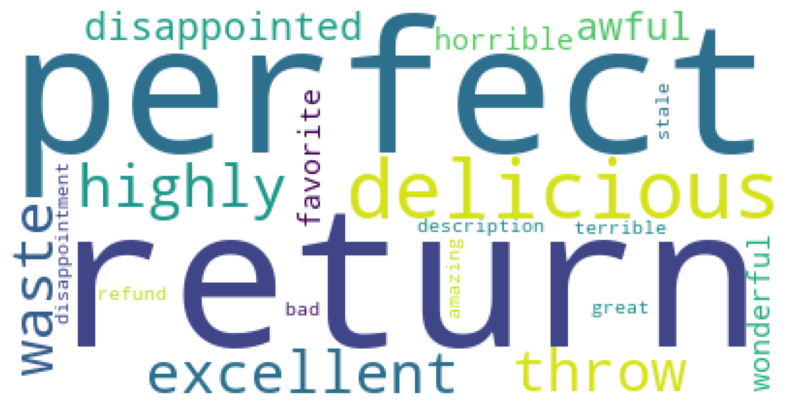

In [30]:
from wordcloud import WordCloud
df = xgbc_bp.feature_importances_
features = bow_features
df = pd.DataFrame(df,columns=['coef'],index=features)
top = df.sort_values(by='coef',ascending=False).head(20)
print('Top 20 features are: \n {}'.format(top))
top['words'] = top.index
top.reset_index(drop=True)
sent = top.words.str.cat(sep=' ')
#word cloud representation
wordcloud = WordCloud(background_color='white').generate(sent)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 2. TFIDF

In [10]:
# X_train_tfidf = pickle.load(open('tfidf_vectors/X_train_tfidf','rb'))
# X_test_tfidf = pickle.load(open('tfidf_vectors/X_test_tfidf','rb'))
# tfidf_features = pickle.load(open('tfidf_vectors/tfidf_features','rb'))

In [12]:
# xgbc2 = XGBClassifier()
# num_estimator = [5,10,50,100,120]
# maximum_depth = [1, 5, 7, 10, 15, 25, 30]
# parameter = {
#     'n_estimators': num_estimator,
#     'max_depth': maximum_depth
# }
# grid2 = GridSearchCV(estimator = xgbc2, param_grid = parameter , cv = 2, n_jobs= -1, scoring= 'roc_auc', return_train_score = True )
# grid2.fit(X_train_tfidf,y_train)

# print('Best Parameter:',grid2.best_params_)

# Taking too much time in TIDF

In [3]:
from prettytable import PrettyTable

In [5]:
z = PrettyTable()

z.field_names = ["Vector","Algorithm","Hyperparam-min_sample_splits","Hyperparam-max_Depth","Train AUC", "Test AUC"]
z.add_row(["bow","XGBoost",120,10, 0.97,0.89])
print(z)


+--------+-----------+------------------------------+----------------------+-----------+----------+
| Vector | Algorithm | Hyperparam-min_sample_splits | Hyperparam-max_Depth | Train AUC | Test AUC |
+--------+-----------+------------------------------+----------------------+-----------+----------+
|  bow   |  XGBoost  |             120              |          10          |    0.97   |   0.89   |
+--------+-----------+------------------------------+----------------------+-----------+----------+


## In Traning XGboostClassifier showing overfitting